In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
from scipy.stats import chi2_contingency, spearmanr, ttest_ind
from sklearn.metrics import cohen_kappa_score
from scipy.stats import kruskal, mannwhitneyu

In [2]:
data = pd.read_csv("issue-v2-description-scored.csv", sep=',')

data['created'] = pd.to_datetime(data['created'], format='%a, %d %b %Y %H:%M:%S %z')
data['resolved'] = pd.to_datetime(data['resolved'], format='%a, %d %b %Y %H:%M:%S %z')

data['duration'] = (data['resolved'] - data['created']).dt.total_seconds() / 3600  # in hours

print(data['roberta'].value_counts())
print(data['bert'].value_counts())


roberta
neutral     582
negative    321
positive     23
Name: count, dtype: int64
bert
neutral     578
negative    306
positive     42
Name: count, dtype: int64


In [7]:
# Convert `created` and `resolved` to datetime format
data["created"] = pd.to_datetime(data["created"])
data["resolved"] = pd.to_datetime(data["resolved"])

# Extract year from the timestamps
data["created_year"] = data["created"].dt.year
data["resolved_year"] = data["resolved"].dt.year

# Count SATD occurrences per year
satd_per_year = data.groupby("created_year").size().reset_index(name="SATD_Count")

# Count resolved SATD per year
resolved_per_year = data.dropna(subset=["resolved"]).groupby("resolved_year").size().reset_index(name="Resolved_Count")

# Merge to see trends
satd_trend = pd.merge(satd_per_year, resolved_per_year, left_on="created_year", right_on="resolved_year", how="left").fillna(0)

# Rename columns
satd_trend.rename(columns={"created_year": "Year", "Resolved_Count": "Resolved_SATD"}, inplace=True)
satd_trend.drop(columns=["resolved_year"], inplace=True)

# Display SATD trends

tools.display_dataframe_to_user(name="SATD Trends Over Time", dataframe=satd_trend)


SATD Trends Over Time


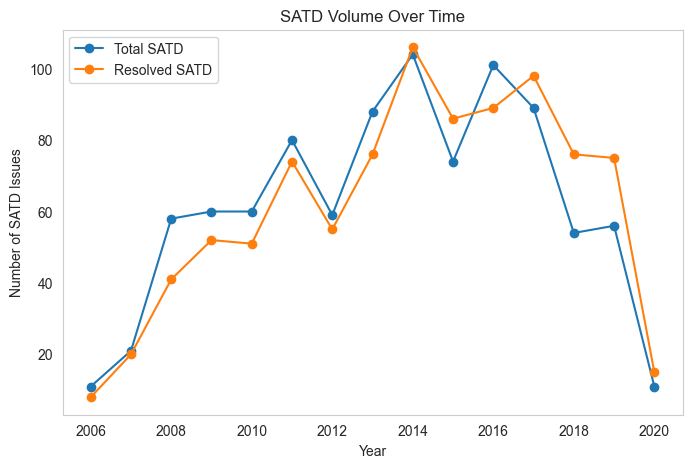

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(satd_trend["Year"], satd_trend["SATD_Count"], label="Total SATD", marker="o")
plt.plot(satd_trend["Year"], satd_trend["Resolved_SATD"], label="Resolved SATD", marker="o")

plt.xlabel("Year")
plt.ylabel("Number of SATD Issues")
plt.title("SATD Volume Over Time")
plt.legend()
plt.grid()
plt.show()


SATD Nature Trends


<Figure size 800x500 with 0 Axes>

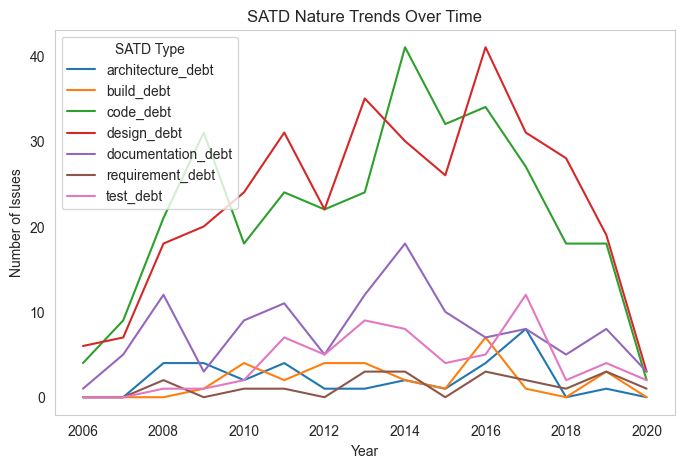

In [9]:
# Count SATD categories per year
satd_nature_trend = data.groupby(["created_year", "classification"]).size().unstack(fill_value=0)

# Display SATD nature trends over time
tools.display_dataframe_to_user(name="SATD Nature Trends", dataframe=satd_nature_trend)

plt.figure(figsize=(8, 5))
satd_nature_trend.plot(kind="line", figsize=(8, 5))
plt.xlabel("Year")
plt.ylabel("Number of Issues")
plt.title("SATD Nature Trends Over Time")
plt.legend(title="SATD Type")
plt.grid()
plt.show()


SATD Sentiment Trends


<Figure size 800x500 with 0 Axes>

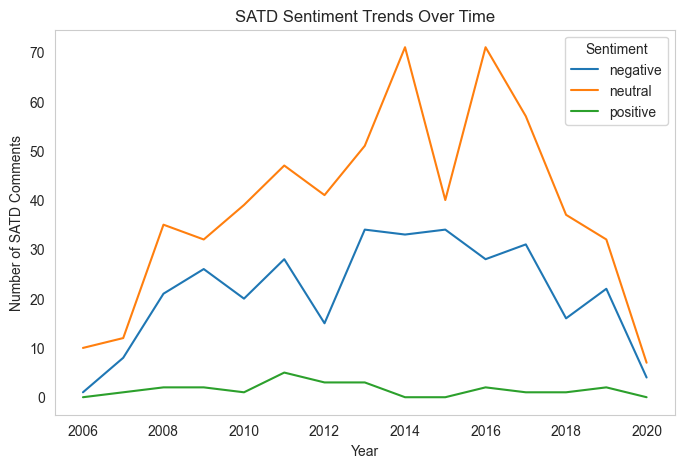

In [10]:
# Count sentiment per year
sentiment_trend = data.groupby(["created_year", "roberta"]).size().unstack(fill_value=0)

# Display sentiment trends
tools.display_dataframe_to_user(name="SATD Sentiment Trends", dataframe=sentiment_trend)

plt.figure(figsize=(8, 5))
sentiment_trend.plot(kind="line", figsize=(8, 5))
plt.xlabel("Year")
plt.ylabel("Number of SATD Comments")
plt.title("SATD Sentiment Trends Over Time")
plt.legend(title="Sentiment")
plt.grid()
plt.show()


## Descriptive Statistics

## RoBERTa

project
camel     137
hadoop    197
hbase     171
impala    197
thrift    224
dtype: int64
roberta  negative  neutral  positive
project                             
camel          37       92         8
hadoop         58      136         3
hbase          73       97         1
impala         58      137         2
thrift         95      120         9
project  roberta 
camel    negative     1216.935728
         neutral      4204.631754
         positive     5204.590833
hadoop   negative     5105.029952
         neutral      4708.799865
         positive    16812.067778
hbase    negative     4124.369756
         neutral      4765.256280
         positive    81049.888611
impala   negative     4808.748755
         neutral      2966.449852
         positive      412.976806
thrift   negative     4393.717164
         neutral      5813.697919
         positive     8189.003086
Name: duration, dtype: float64


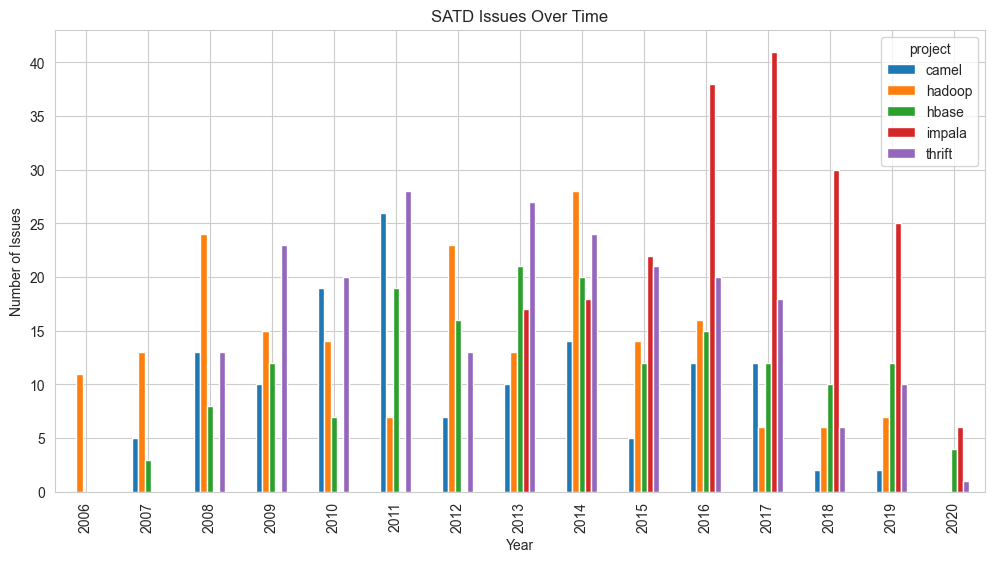

In [4]:
# Count SATD issues by project
satd_counts = data.groupby('project').size()
print(satd_counts)

# Sentiment distribution by project
sentiment_by_project = data.groupby(['project', 'roberta']).size().unstack(fill_value=0)
print(sentiment_by_project)

# Average duration by project and sentiment
avg_duration = data.groupby(['project', 'roberta'])['duration'].mean()
print(avg_duration)

data['created_year'] = data['created'].dt.year
issues_over_time = data.groupby(['project', 'created_year']).size().unstack(fill_value=0)

issues_over_time.T.plot(kind='bar', figsize=(12, 6), title="SATD Issues Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.show()


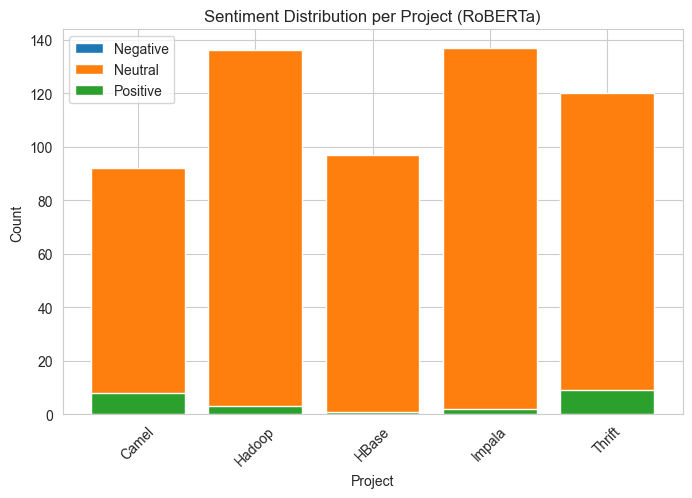

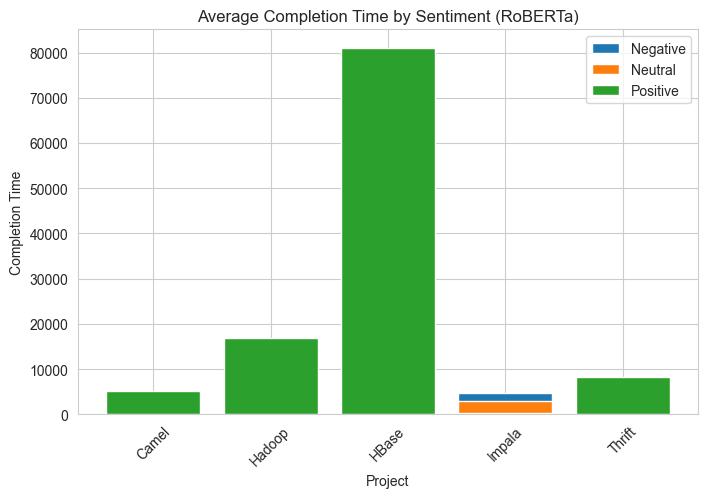

<Figure size 800x500 with 0 Axes>

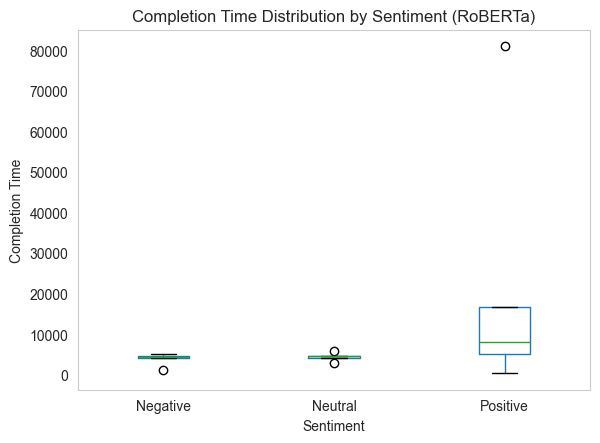

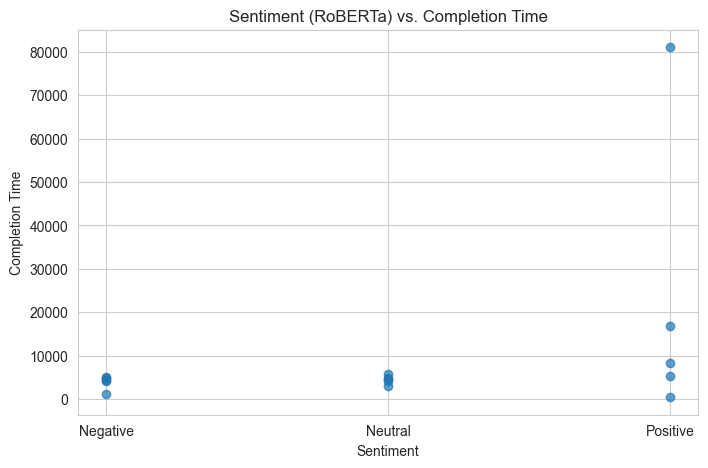

In [5]:
sentiment_distribution = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [37, 58, 73, 58, 95],
    "Neutral": [92, 136, 97, 137, 120],
    "Positive": [8, 3, 1, 2, 9]
})

# Average completion
completion_time = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [1216.94, 5105.03, 4124.37, 4808.75, 4393.72],
    "Neutral": [4204.63, 4708.79, 4765.26, 2966.45, 5813.69],
    "Positive": [5204.59, 16812.07, 81049.88, 412.97, 8189]  
})

sentiment_distribution_long = sentiment_distribution.melt(id_vars="Project", var_name="Sentiment", value_name="Count")
completion_time_long = completion_time.melt(id_vars="Project", var_name="Sentiment", value_name="Completion Time")

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = sentiment_distribution_long[sentiment_distribution_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Count"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Count")
plt.title("Sentiment Distribution per Project (RoBERTa)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = completion_time_long[completion_time_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Completion Time"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Completion Time")
plt.title("Average Completion Time by Sentiment (RoBERTa)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
completion_time_long.boxplot(by="Sentiment", column="Completion Time", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Completion Time Distribution by Sentiment (RoBERTa)")
plt.suptitle("")
plt.show()


plt.figure(figsize=(8, 5))
sentiment_mapping = {"Negative": 1, "Neutral": 2, "Positive": 3}
completion_time_long["Sentiment Numeric"] = completion_time_long["Sentiment"].map(sentiment_mapping)
plt.scatter(completion_time_long["Sentiment Numeric"], completion_time_long["Completion Time"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Sentiment (RoBERTa) vs. Completion Time")
plt.show()


In [6]:
positive_durations = data[data["roberta"] == "positive"]["duration"]
neutral_durations = data[data["roberta"] == "neutral"]["duration"]
negative_durations = data[data["roberta"] == "negative"]["duration"]

# Kruskal-Wallis
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print("\n=== Kruskal-Wallis H Test ===")
print(f"Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference found between sentiment groups. Proceeding with pairwise tests.\n")
else:
    print("No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.")
    exit() 

# Pairwise Mann-Whitney U Tests
print("\n=== Pairwise Mann-Whitney U Tests ===")
comparisons = [("negative", "positive"), ("negative", "neutral")]
for group1, group2 in comparisons:
    group1_durations = data[data["roberta"] == group1]["duration"]
    group2_durations = data[data["roberta"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Comparing {group1} vs {group2}:")
    print(f"  - Mann-Whitney U Statistic: {u_stat}")
    print(f"  - P-value: {p_value}")

    if p_value < 0.05:
        print(f"  - **Reject H₀**: {group1} sentiment issues take significantly longer to resolve than {group2} issues.\n")
    else:
        print(f"  - **Fail to reject H₀**: No significant difference between {group1} and {group2} in resolution time.\n")



=== Kruskal-Wallis H Test ===
Test Statistic: 6.793306794872633, P-value: 0.033485144125904955
Significant difference found between sentiment groups. Proceeding with pairwise tests.


=== Pairwise Mann-Whitney U Tests ===
Comparing negative vs positive:
  - Mann-Whitney U Statistic: 2535.0
  - P-value: 0.993985570003327
  - **Fail to reject H₀**: No significant difference between negative and positive in resolution time.

Comparing negative vs neutral:
  - Mann-Whitney U Statistic: 90061.0
  - P-value: 0.8140992532956468
  - **Fail to reject H₀**: No significant difference between negative and neutral in resolution time.


## BERT

project
camel     137
hadoop    197
hbase     171
impala    197
thrift    224
dtype: int64
bert     negative  neutral  positive
project                             
camel          31       96        10
hadoop         67      125         5
hbase          63      104         4
impala         59      128        10
thrift         86      125        13
project  bert    
camel    negative      350.424480
         neutral      4563.918530
         positive     2449.013222
hadoop   negative     4697.213197
         neutral      4597.266222
         positive    19510.632056
hbase    negative     3452.030750
         neutral      5179.068854
         positive    22064.410486
impala   negative     3730.396563
         neutral      3527.507995
         positive     1452.259056
thrift   negative     4367.306776
         neutral      5821.942118
         positive     6570.520085
Name: duration, dtype: float64


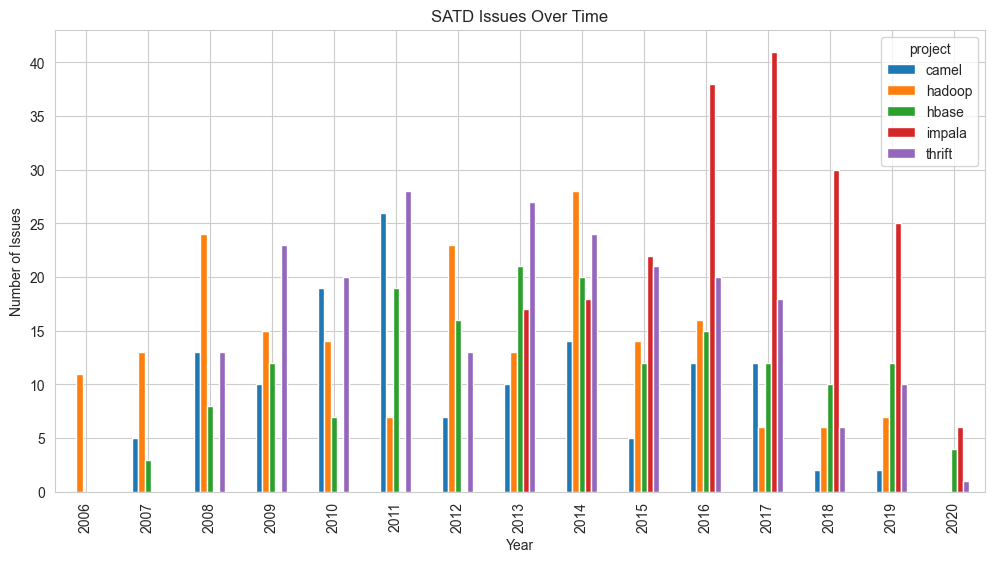

In [7]:
# Count SATD issues by project
satd_counts = data.groupby('project').size()
print(satd_counts)

# Sentiment distribution by project
sentiment_by_project = data.groupby(['project', 'bert']).size().unstack(fill_value=0)
print(sentiment_by_project)

# Average duration by project and sentiment
avg_duration = data.groupby(['project', 'bert'])['duration'].mean()
print(avg_duration)

data['created_year'] = data['created'].dt.year
issues_over_time = data.groupby(['project', 'created_year']).size().unstack(fill_value=0)

issues_over_time.T.plot(kind='bar', figsize=(12, 6), title="SATD Issues Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.show()


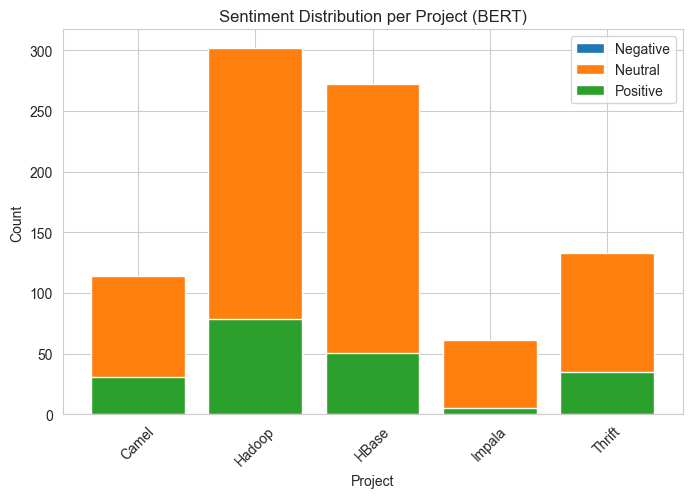

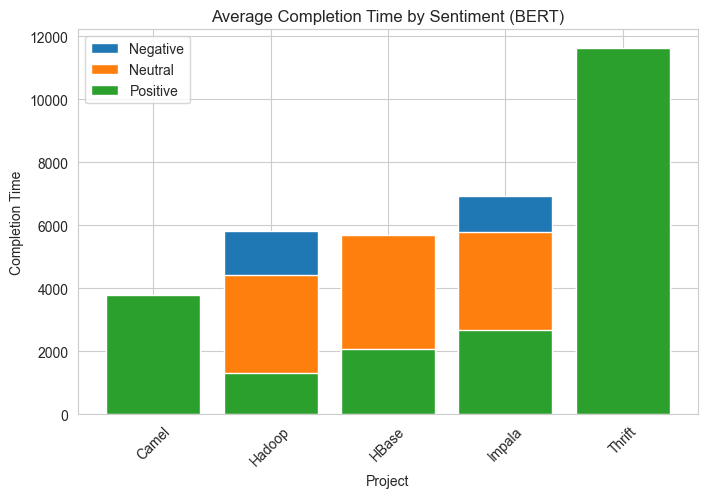

<Figure size 800x500 with 0 Axes>

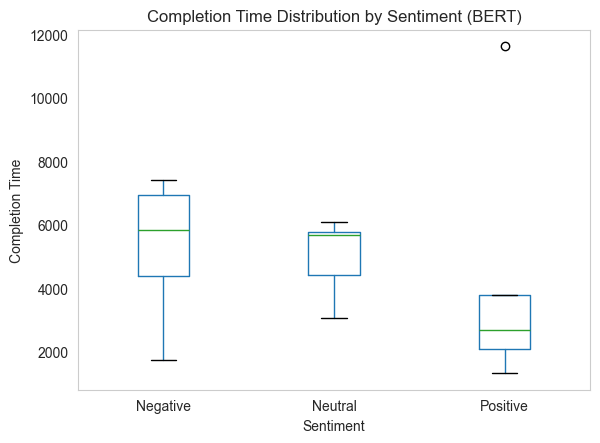

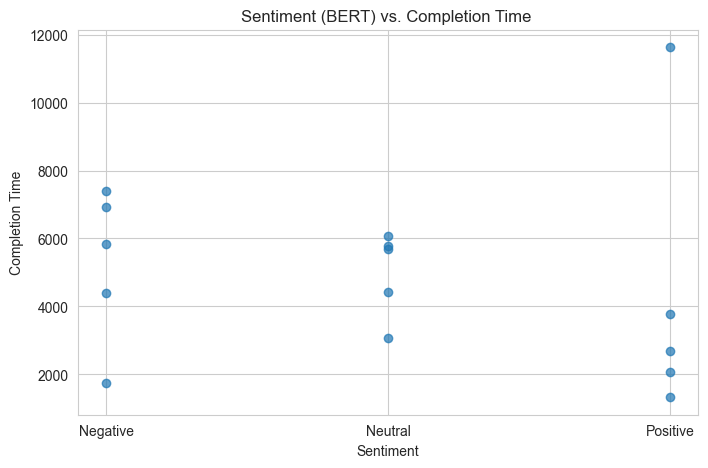

In [9]:
sentiment_distribution = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [41, 132, 102, 13, 52],
    "Neutral": [114, 302, 272, 61, 133],
    "Positive": [31, 79, 51, 5, 35]
})

# Average completion time per sentiment per project (BERT)
completion_time = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [1732.21, 5834.05, 4379.94, 6932.17, 7411.72],
    "Neutral": [3072.92, 4432.88, 5680.45, 5773.88, 6084.14],
    "Positive": [3788.49, 1325.46, 2077.21, 2690.67, 11631.1]  
})

sentiment_distribution_long = sentiment_distribution.melt(id_vars="Project", var_name="Sentiment", value_name="Count")
completion_time_long = completion_time.melt(id_vars="Project", var_name="Sentiment", value_name="Completion Time")

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = sentiment_distribution_long[sentiment_distribution_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Count"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Count")
plt.title("Sentiment Distribution per Project (BERT)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = completion_time_long[completion_time_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Completion Time"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Completion Time")
plt.title("Average Completion Time by Sentiment (BERT)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
completion_time_long.boxplot(by="Sentiment", column="Completion Time", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Completion Time Distribution by Sentiment (BERT)")
plt.suptitle("")
plt.show()


plt.figure(figsize=(8, 5))
sentiment_mapping = {"Negative": 1, "Neutral": 2, "Positive": 3}
completion_time_long["Sentiment Numeric"] = completion_time_long["Sentiment"].map(sentiment_mapping)
plt.scatter(completion_time_long["Sentiment Numeric"], completion_time_long["Completion Time"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Sentiment (BERT) vs. Completion Time ")
plt.show()


In [10]:
positive_durations = data[data["bert"] == "positive"]["duration"]
neutral_durations = data[data["bert"] == "neutral"]["duration"]
negative_durations = data[data["bert"] == "negative"]["duration"]

# Kruskal-Wallis
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print("\n=== Kruskal-Wallis H Test ===")
print(f"Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference found between sentiment groups. Proceeding with pairwise tests.\n")
else:
    print("No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.")
    exit() 

# Pairwise Mann-Whitney U Tests
print("\n=== Pairwise Mann-Whitney U Tests ===")
comparisons = [("negative", "positive"), ("negative", "neutral")]
for group1, group2 in comparisons:
    group1_durations = data[data["bert"] == group1]["duration"]
    group2_durations = data[data["bert"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Comparing {group1} vs {group2}:")
    print(f"  - Mann-Whitney U Statistic: {u_stat}")
    print(f"  - P-value: {p_value}")

    if p_value < 0.05:
        print(f"  - **Reject H₀**: {group1} sentiment issues take significantly longer to resolve than {group2} issues.\n")
    else:
        print(f"  - **Fail to reject H₀**: No significant difference between {group1} and {group2} in resolution time.\n")



=== Kruskal-Wallis H Test ===
Test Statistic: 4.146155308658775, P-value: 0.12579802248815317
No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.

=== Pairwise Mann-Whitney U Tests ===
Comparing negative vs positive:
  - Mann-Whitney U Statistic: 5393.0
  - P-value: 0.9545293131647863
  - **Fail to reject H₀**: No significant difference between negative and positive in resolution time.

Comparing negative vs neutral:
  - Mann-Whitney U Statistic: 82979.0
  - P-value: 0.9345456848604251
  - **Fail to reject H₀**: No significant difference between negative and neutral in resolution time.


## Temporal Trends

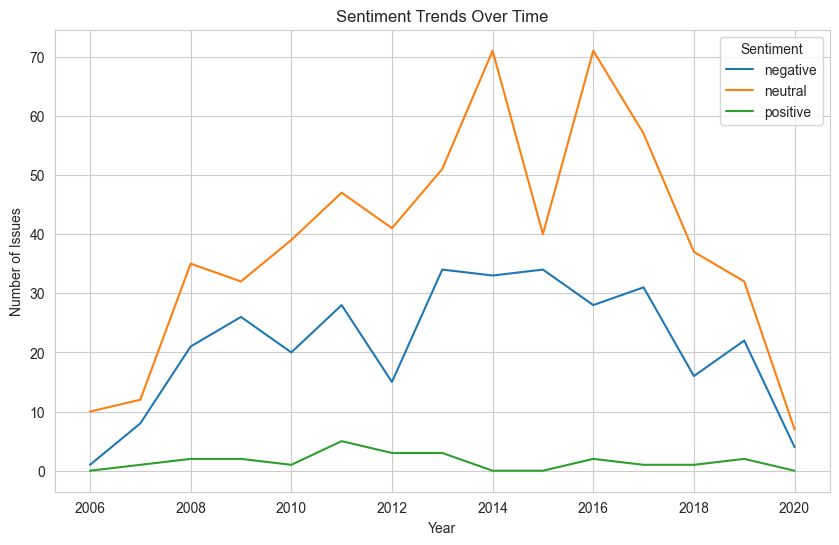

In [4]:
# Sentiment trends
sentiment_trends = data.groupby(['created_year', 'roberta']).size().unstack(fill_value=0)

sentiment_trends.plot(kind='line', figsize=(10, 6), title="Sentiment Trends Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.show()


## Statistical Tests

In [5]:
# Spearman correlation between duration and sentiment
data['roberta_numeric'] = data['roberta'].map({'positive': 1, 'neutral': 0, 'negative': -1})
correlation, p_value = spearmanr(data['duration'], data['roberta_numeric'])
print(f"Spearman Correlation: {correlation}, P-value: {p_value}")


Spearman Correlation: 0.05334073033723853, P-value: 0.10477464017515146


In [6]:
# Contingency table: sentiment vs project
contingency_table = pd.crosstab(data['project'], data['roberta'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, P-value: {p}")


Chi-square statistic: 32.82710680774827, P-value: 6.616581703750165e-05


In [7]:
# Cohen's kappa for agreement
agreement = cohen_kappa_score(data['roberta'], data['bert'])
print(f"Cohen's Kappa: {agreement}")


Cohen's Kappa: 0.6861299681432038


## Separating data based on models

In [8]:
# Agreement analysis: RoBERTa vs BERT
from sklearn.metrics import confusion_matrix, cohen_kappa_score

conf_matrix = pd.crosstab(data['roberta'], data['bert'])
print("Confusion Matrix:")
print(conf_matrix)

kappa = cohen_kappa_score(data['roberta'], data['bert'])
print(f"Cohen's Kappa: {kappa}")


Confusion Matrix:
bert      negative  neutral  positive
roberta                              
negative       258       62         1
neutral         48      509        25
positive         0        7        16
Cohen's Kappa: 0.6861299681432038


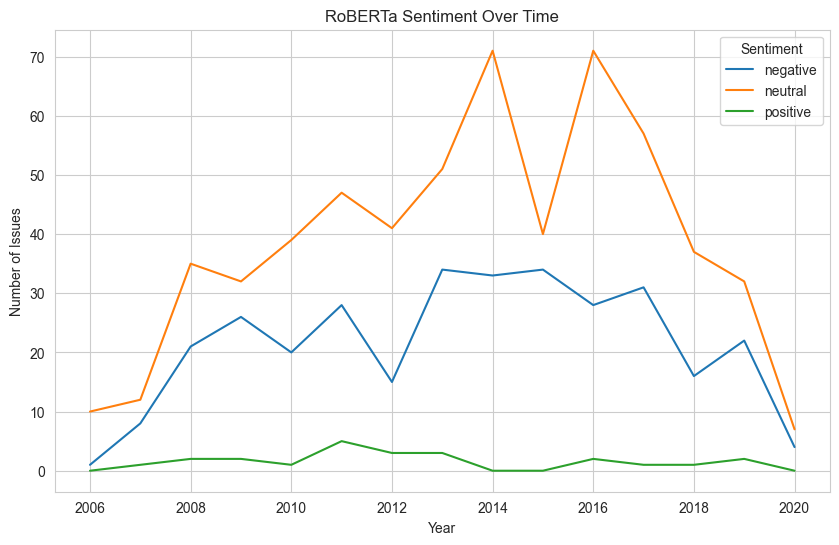

In [9]:
# RoBERTa
roberta_trends = data.groupby(['created_year', 'roberta']).size().unstack(fill_value=0)
roberta_trends.plot(kind='line', figsize=(10, 6), title="RoBERTa Sentiment Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.show()


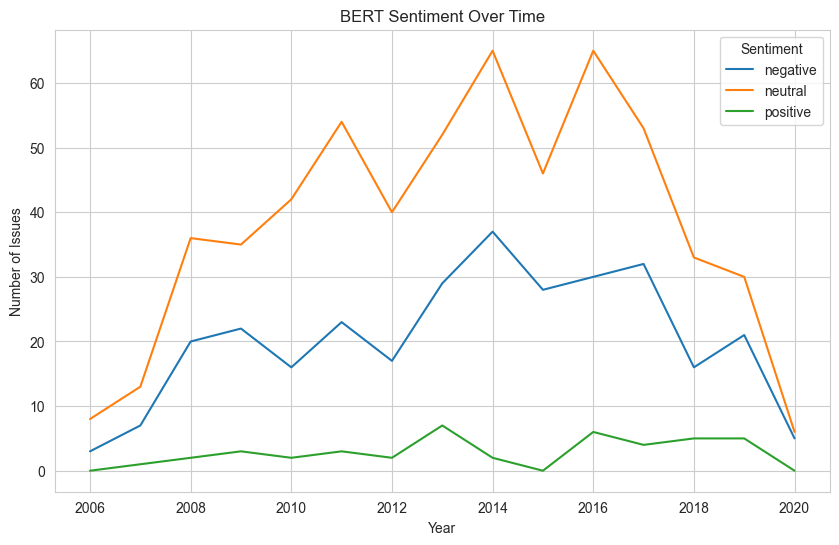

In [10]:
# BERT
bert_trends = data.groupby(['created_year', 'bert']).size().unstack(fill_value=0)
bert_trends.plot(kind='line', figsize=(10, 6), title="BERT Sentiment Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.show()


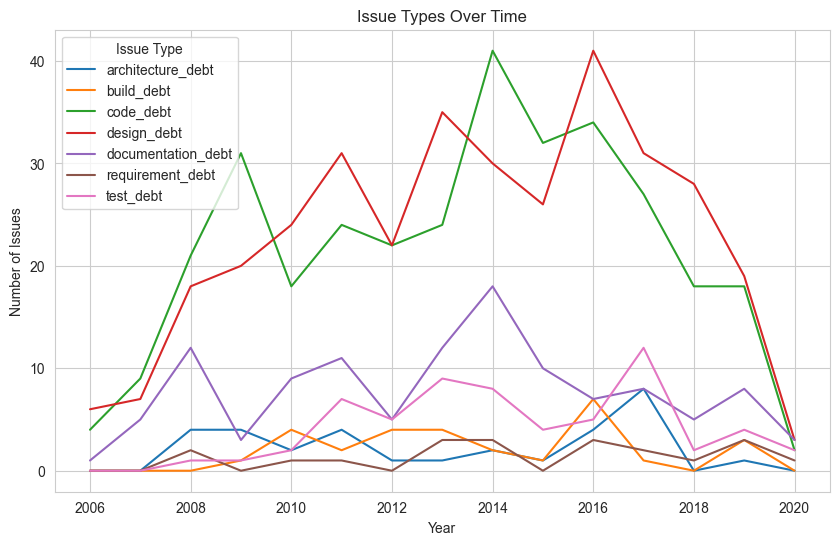

In [11]:
issue_type_trends = data.groupby(['created_year', 'classification']).size().unstack(fill_value=0)
issue_type_trends.plot(kind='line', figsize=(10, 6), title="Issue Types Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Issue Type")
plt.show()


In [12]:
disagreements = data[data['roberta'] != data['bert']]

#disagreement
disagreement_by_project = disagreements.groupby('project').size()
disagreement_by_issue_type = disagreements.groupby('classification').size()


print("Disagreements by Project:")
print(disagreement_by_project)
print("\nDisagreements by Issue Type:")
print(disagreement_by_issue_type)


Disagreements by Project:
project
camel     22
hadoop    33
hbase     23
impala    33
thrift    32
dtype: int64

Disagreements by Issue Type:
classification
architecture_debt      5
build_debt             3
code_debt             63
design_debt           42
documentation_debt    17
requirement_debt       2
test_debt             11
dtype: int64


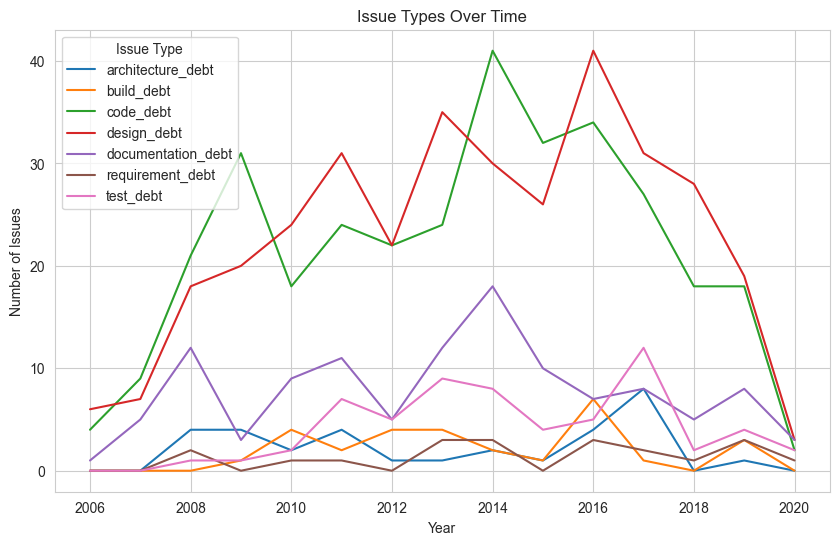

In [13]:
#Volume and Nature SATD by issue type

issue_type_trends = data.groupby(['created_year', 'classification']).size().unstack(fill_value=0)
issue_type_trends.plot(kind='line', figsize=(10, 6), title="Issue Types Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.legend(title="Issue Type")
plt.show()


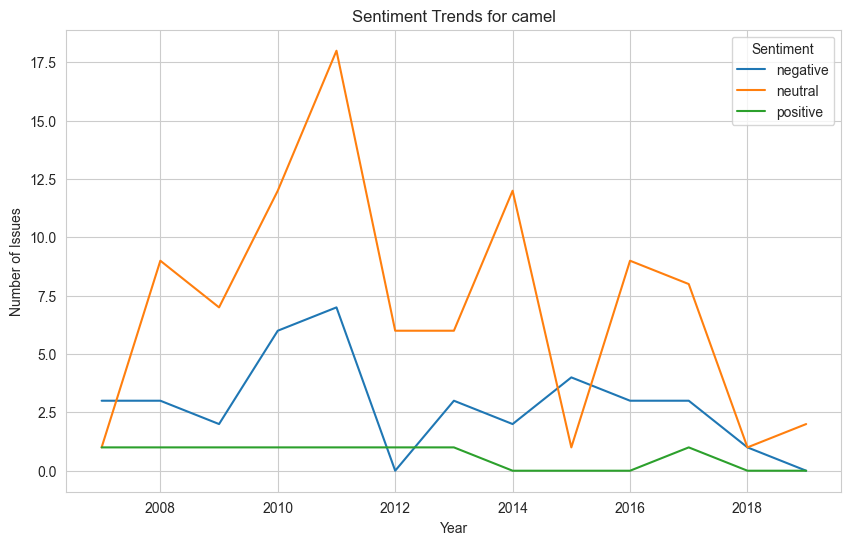

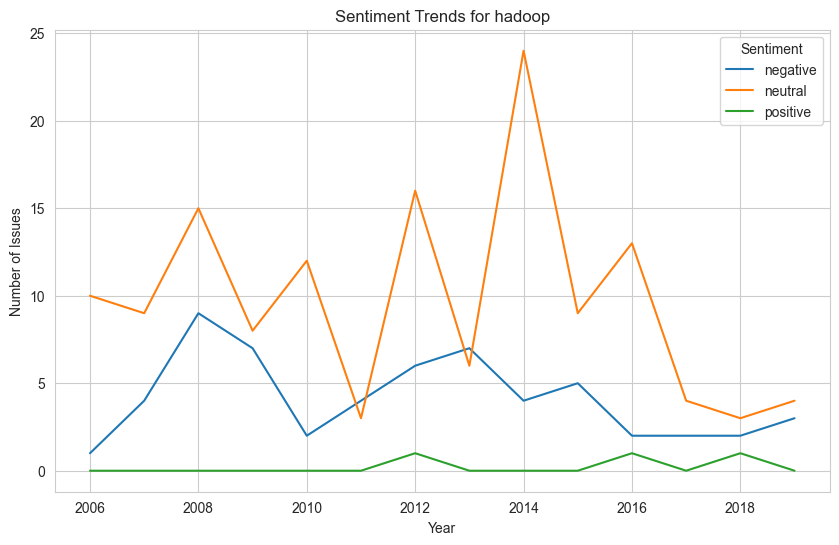

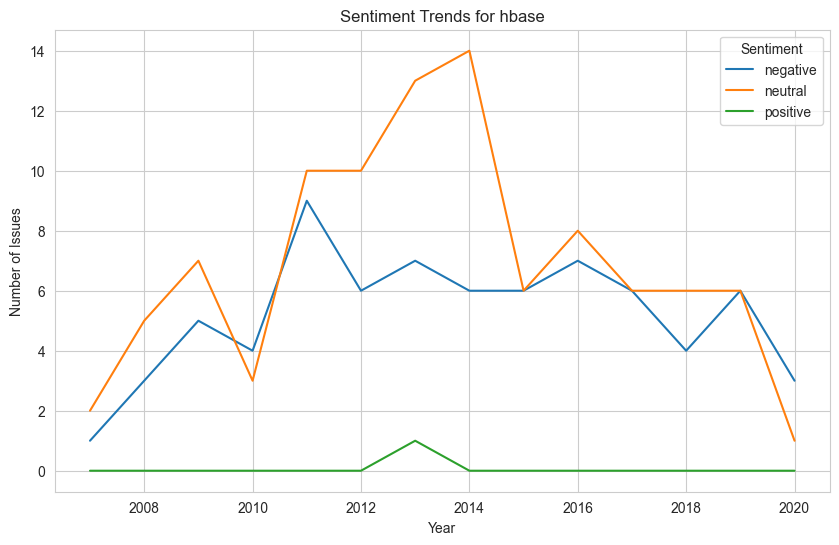

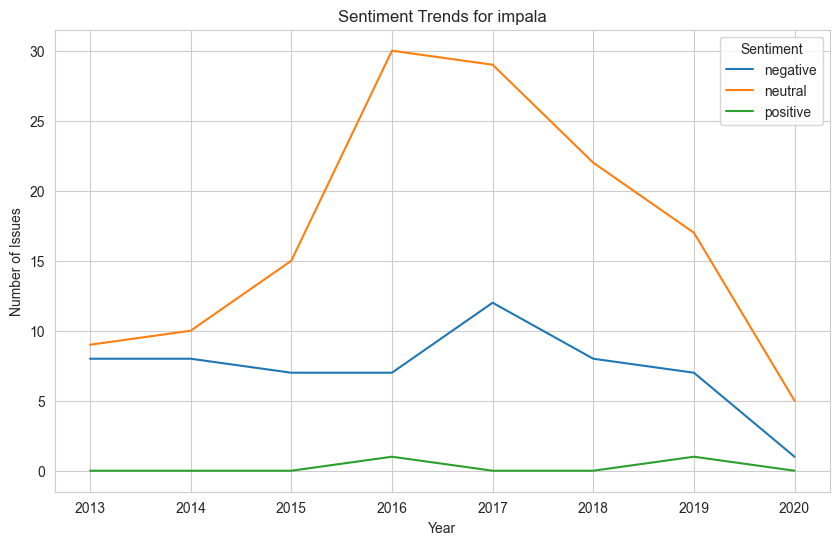

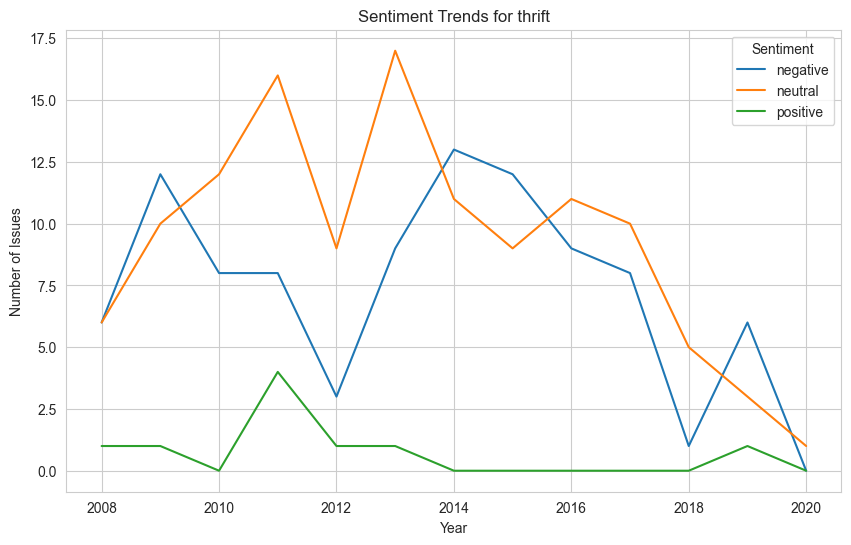

In [14]:
for project in data['project'].unique():
    project_data = data[data['project'] == project]
    sentiment_trends = project_data.groupby(['created_year', 'roberta']).size().unstack(fill_value=0)
    sentiment_trends.plot(kind='line', figsize=(10, 6), title=f"Sentiment Trends for {project}")
    plt.ylabel("Number of Issues")
    plt.xlabel("Year")
    plt.legend(title="Sentiment")
    plt.show()


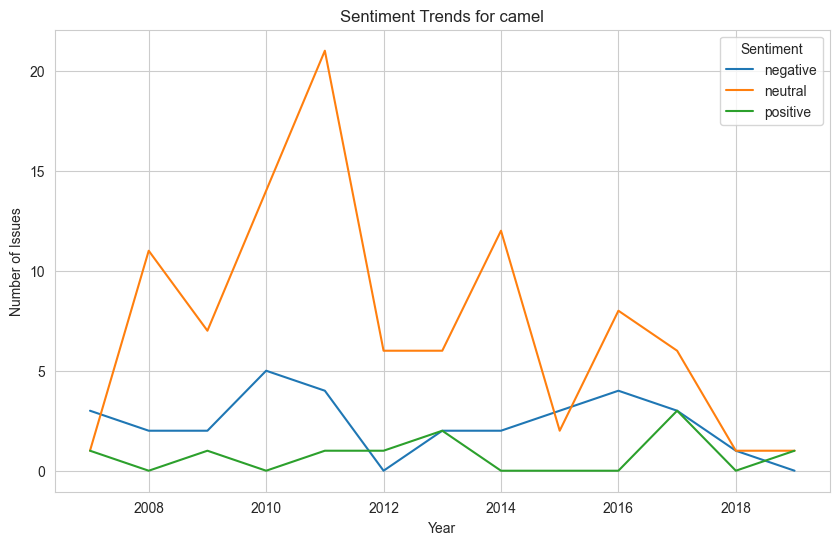

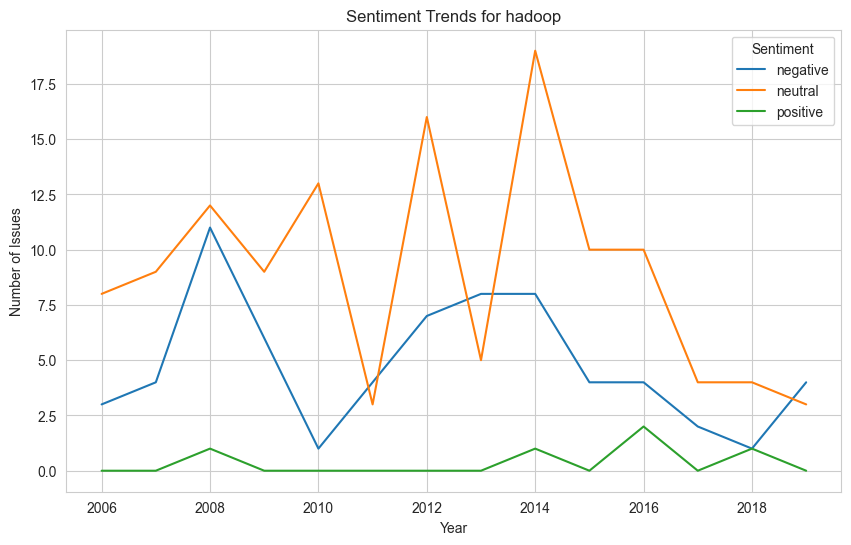

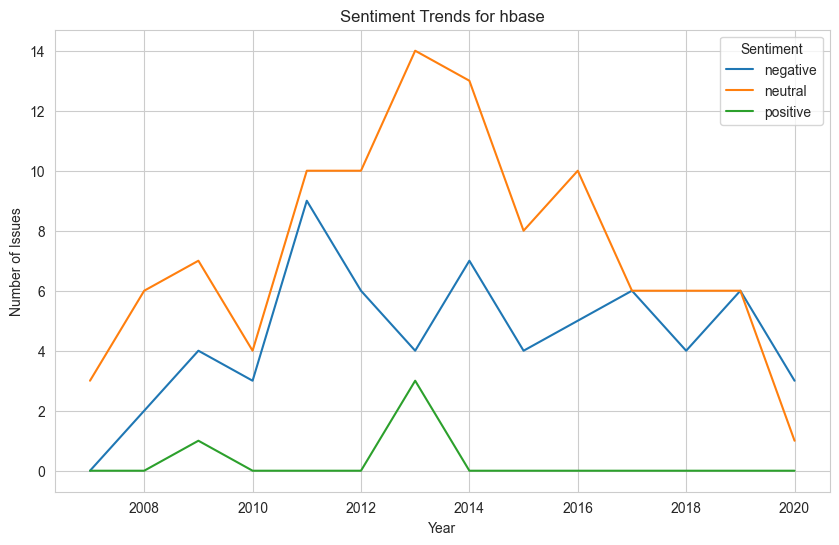

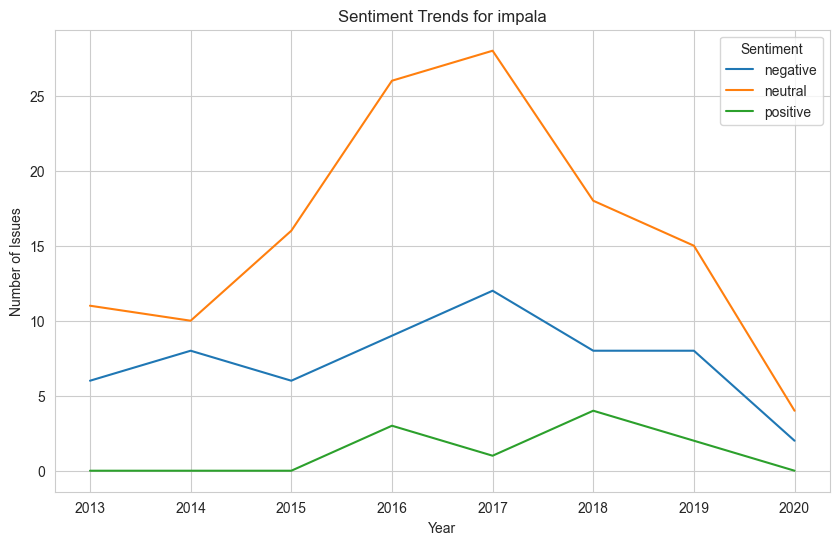

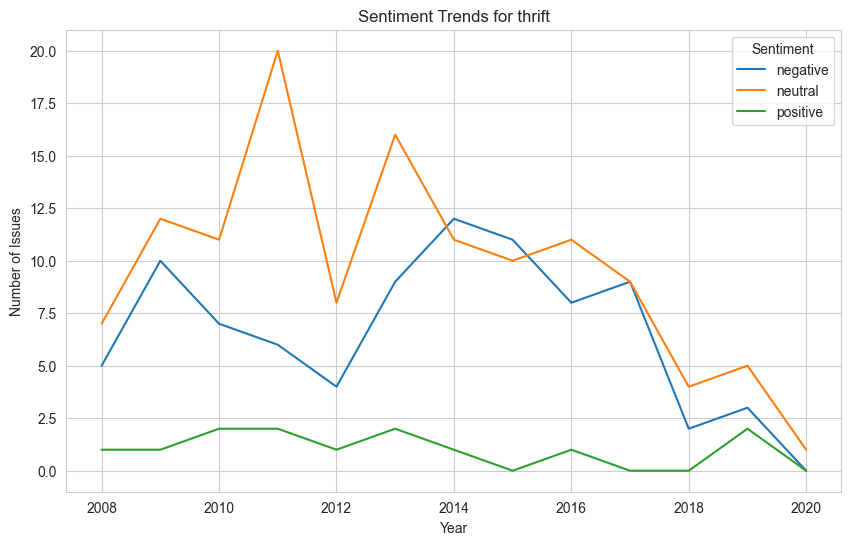

In [15]:
for project in data['project'].unique():
    project_data = data[data['project'] == project]
    sentiment_trends = project_data.groupby(['created_year', 'bert']).size().unstack(fill_value=0)
    sentiment_trends.plot(kind='line', figsize=(10, 6), title=f"Sentiment Trends for {project}")
    plt.ylabel("Number of Issues")
    plt.xlabel("Year")
    plt.legend(title="Sentiment")
    plt.show()


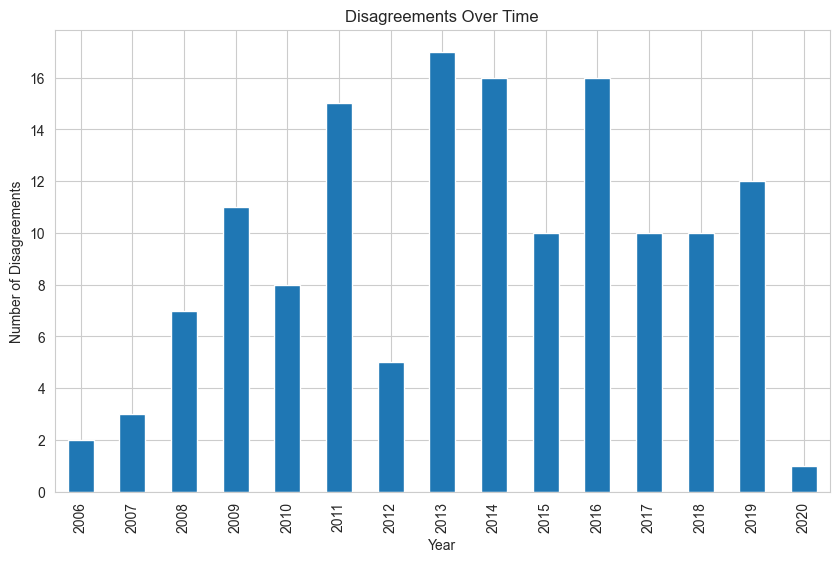

In [16]:
disagreements = data[data['roberta'] != data['bert']]
disagreement_by_year = disagreements.groupby('created_year').size()
disagreement_by_year.plot(kind='bar', figsize=(10, 6), title="Disagreements Over Time")
plt.ylabel("Number of Disagreements")
plt.xlabel("Year")
plt.show()


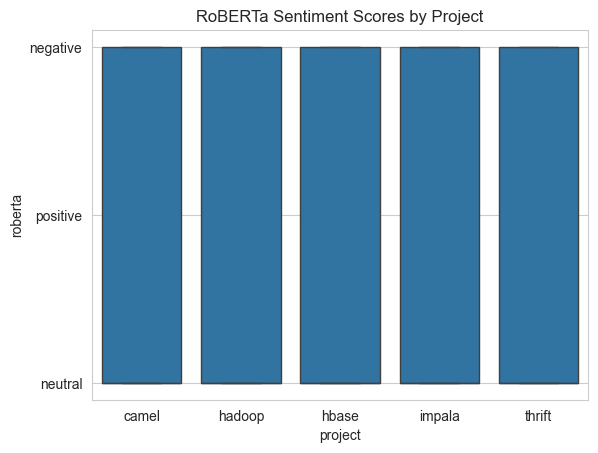

In [17]:
sns.boxplot(x='project', y='roberta', data=data)
plt.title("RoBERTa Sentiment Scores by Project")
plt.show()

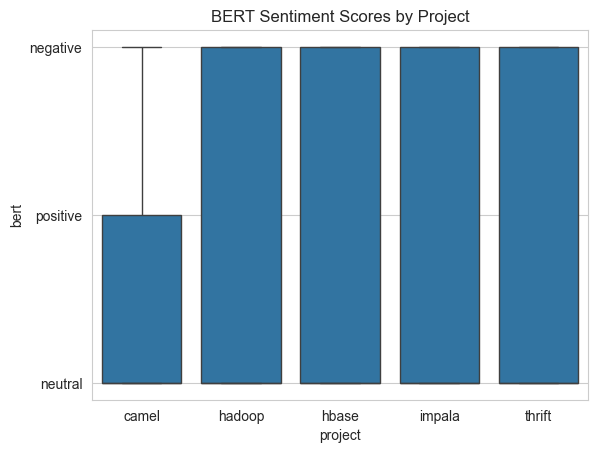

In [18]:
sns.boxplot(x='project', y='bert', data=data)
plt.title("BERT Sentiment Scores by Project")
plt.show()